In [101]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings("ignore")

In [102]:
data = pd.read_csv('Data/BeerWineLiquor.csv')
data['date'] = pd.to_datetime(data['date'], format='%m/%d/%Y')
data.set_index('date', inplace=True)

In [103]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 324 entries, 1992-01-01 to 2018-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   beer    324 non-null    int64
dtypes: int64(1)
memory usage: 5.1 KB


In [104]:
data.head()

,beer
date,
1992-01-01,1509
1992-02-01,1541
1992-03-01,1597
1992-04-01,1675
1992-05-01,1822


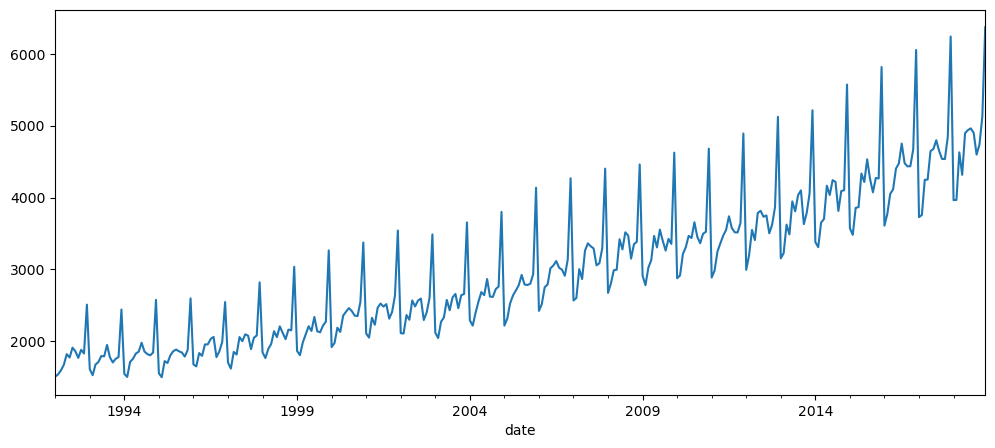

In [105]:
data['beer'].plot(figsize=(12,5));

In [106]:
# Kiểm tra tính dừng của chuỗi dữ liệu bằng ADF Test
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("Chuỗi dừng (không có đơn vị gốc)")
    else:
        print("Chuỗi không dừng (có đơn vị gốc)")

adf_test(data['beer'])

ADF Statistic: 2.86430850789725
p-value: 1.0
Chuỗi không dừng (có đơn vị gốc)


**nhận xét**
1. Chuỗi không dừng: Với p-value là 1.0 (lớn hơn 0.05), kiểm tra ADF cho thấy chuỗi này không dừng và có đơn vị gốc (unit root). Điều này có nghĩa là chuỗi có xu hướng thay đổi trung bình theo thời gian và không ổn định, có thể có xu hướng hoặc chu kỳ mà không tự trở lại trung bình cố định.

2. Cần xử lý để làm cho chuỗi trở nên dừng: Để áp dụng các mô hình dự báo như ARIMA hoặc SARIMA hiệu quả, chuỗi này cần phải được chuyển thành chuỗi dừng. Một cách phổ biến để làm điều này là sử dụng sai phân (differencing). Ví dụ, nếu chuỗi có xu hướng tuyến tính, lấy sai phân bậc 1 có thể giúp chuỗi trở nên dừng.

3. Bước tiếp theo: Thử lấy sai phân bậc 1 (hoặc bậc cao hơn nếu cần) và thực hiện lại kiểm tra ADF để xem liệu chuỗi đã trở thành dừng hay chưa. Nếu chuỗi trở thành dừng, ta có thể tiếp tục xây dựng các mô hình ARIMA hoặc SARIMA để dự báo.

In [108]:
# Lấy sai phân bậc 1
data_diff = data['beer'].diff().dropna()

# Kiểm tra tính dừng của chuỗi đã sai phân với tiêu đề
adf_test(data_diff, title="Differenced Series")

ADF Statistic: -4.033255052422637
p-value: 0.0012460469107307185
Chuỗi dừng (không có đơn vị gốc)


**nhận xét**
1. ADF test statistic: Giá trị ADF là -4.033255, nhỏ hơn tất cả các giá trị tới hạn (critical values) ở các mức ý nghĩa 1%, 5%, và 10%. Điều này cho thấy chuỗi đã vượt qua ngưỡng để bác bỏ giả thuyết gốc với mức độ tin cậy cao.

2. p-value: Giá trị p-value là 0.001246, thấp hơn 0.05 (mức ý nghĩa phổ biến). Điều này cung cấp bằng chứng mạnh mẽ để bác bỏ giả thuyết gốc rằng chuỗi có đơn vị gốc (non-stationary). Nói cách khác, sau khi lấy sai phân, chuỗi đã đạt tính dừng.

3. Kết luận về tính dừng: Kết quả từ ADF Test cho thấy chúng ta có thể bác bỏ giả thuyết gốc và kết luận rằng chuỗi không có đơn vị gốc và đã trở nên dừng. Điều này có nghĩa là các đặc tính thống kê của chuỗi (như trung bình và phương sai) không thay đổi theo thời gian, làm cho chuỗi phù hợp để áp dụng các mô hình dự báo tuyến tính như ARIMA hoặc SARIMA.

**Ý nghĩa của kết quả**

- Tính dừng là một yêu cầu quan trọng khi áp dụng các mô hình dự báo chuỗi thời gian như ARIMA hoặc SARIMA. Chuỗi dừng giúp các mô hình này dự báo chính xác hơn vì các đặc tính của chuỗi ổn định theo thời gian.
- Vì chuỗi đã đạt tính dừng sau khi lấy sai phân bậc 1, chúng ta có thể sử dụng mô hình ARIMA hoặc SARIMA với tham số d=1 (chỉ số bậc sai phân).

In [110]:
# Tự động chọn tham số cho ARIMA và SARIMA
auto_arima_model = auto_arima(data['beer'], seasonal=True, m=12, trace=True)
arima_order = auto_arima_model.order
seasonal_order = auto_arima_model.seasonal_order

print(f'Tham số ARIMA được chọn: {arima_order}')
print(f'Tham số SARIMA được chọn: {seasonal_order}')

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=3609.756, Time=0.91 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3828.363, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3709.263, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3643.628, Time=0.28 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=3613.374, Time=0.57 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=3618.817, Time=0.43 sec
 ARIMA(2,1,2)(2,1,1)[12]             : AIC=3609.518, Time=1.79 sec
 ARIMA(2,1,2)(2,1,0)[12]             : AIC=3615.656, Time=0.99 sec
 ARIMA(2,1,2)(2,1,2)[12]             : AIC=inf, Time=3.06 sec
 ARIMA(2,1,2)(1,1,2)[12]             : AIC=3610.692, Time=1.80 sec
 ARIMA(1,1,2)(2,1,1)[12]             : AIC=3623.872, Time=1.56 sec
 ARIMA(2,1,1)(2,1,1)[12]             : AIC=3621.013, Time=1.86 sec
 ARIMA(3,1,2)(2,1,1)[12]             : AIC=3605.622, Time=2.64 sec
 ARIMA(3,1,2)(1,1,1)[12]             : AIC=3606.491, Time=1.36 sec
 ARIMA(3,1,2)(2,1,0)[12]

In [111]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train = data['beer'][:-12]
test = data['beer'][-12:]

1. Lý do chọn 12 điểm dữ liệu cuối cùng cho tập kiểm tra

- Dự báo cho 12 tháng tiếp theo: Trong nhiều trường hợp dự báo chuỗi thời gian, đặc biệt là với dữ liệu theo tháng, người ta thường muốn đánh giá mô hình trên khoảng thời gian một năm (12 tháng). Do đó, chọn 12 điểm dữ liệu cuối cùng cho tập kiểm tra giúp đánh giá khả năng của mô hình trong việc dự báo một chu kỳ hoàn chỉnh.

- Giữ lại phần lớn dữ liệu cho huấn luyện: Để đảm bảo rằng mô hình có đủ dữ liệu để học các xu hướng và mẫu, chúng ta chỉ tách ra một phần nhỏ (12 điểm dữ liệu cuối cùng) làm tập kiểm tra, trong khi phần lớn dữ liệu được dùng để huấn luyện.

2. Đảm bảo tính chất thời gian của chuỗi

- Trong chuỗi thời gian, dữ liệu có tính tuần tự và có mối quan hệ theo thời gian. Khi chia dữ liệu, chúng ta cần tôn trọng tính tuần tự này để tránh việc mô hình "nhìn thấy" dữ liệu trong tương lai.

- Bằng cách lấy 12 điểm dữ liệu cuối cùng làm tập kiểm tra, chúng ta đang đảm bảo rằng tập huấn luyện chỉ bao gồm dữ liệu trong quá khứ và mô hình sẽ dự báo cho tương lai (dữ liệu kiểm tra).

3. Đánh giá hiệu suất dự báo

- Sau khi mô hình được huấn luyện trên tập huấn luyện, chúng ta sẽ sử dụng nó để dự báo 12 điểm tiếp theo và so sánh với giá trị thực tế trong tập kiểm tra.

- Các chỉ số như Mean Squared Error (MSE) và Root Mean Squared Error (RMSE) được tính toán dựa trên tập kiểm tra để đánh giá độ chính xác của mô hình.

**Tóm lại**
- Việc chia dữ liệu thành tập huấn luyện (toàn bộ dữ liệu trừ 12 điểm cuối) và tập kiểm tra (12 điểm cuối) là một cách hợp lý để:

+ Đảm bảo mô hình có đủ dữ liệu để học.
+ Đánh giá mô hình trên một chu kỳ 12 tháng tiếp theo (phù hợp nếu dữ liệu có tính mùa vụ hoặc theo chu kỳ).
+ Bảo toàn tính chất tuần tự của dữ liệu chuỗi thời gian, giúp đánh giá chính xác hiệu quả dự báo của mô hình.

In [113]:
# Xây dựng mô hình ARIMA
arima_model = ARIMA(train, order=(4, 1, 3))
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=12)

In [114]:
print(arima_result.summary())


                               SARIMAX Results                                
Dep. Variable:                   beer   No. Observations:                  312
Model:                 ARIMA(4, 1, 3)   Log Likelihood               -2310.634
Date:                Thu, 07 Nov 2024   AIC                           4637.268
Time:                        09:08:53   BIC                           4667.187
Sample:                    01-01-1992   HQIC                          4649.227
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5335      0.624     -0.855      0.393      -1.757       0.690
ar.L2         -0.2142      0.455     -0.471      0.638      -1.106       0.678
ar.L3         -0.2946      0.202     -1.457      0.1

**Nhận xét tổng quan:**
1. Mô hình ARIMA(4, 1, 3) dường như đã được khớp tốt với dữ liệu, với các chỉ số AIC và BIC khá hợp lý, và kiểm định Ljung-Box cho thấy không có tự tương quan trong phần dư.
2. Tuy nhiên, các hệ số của thành phần AR và MA đều không có ý nghĩa thống kê (p-value lớn hơn 0.05), điều này có thể là dấu hiệu rằng mô hình có thể chưa được tối ưu.
3. Phân phối phần dư không chuẩn và có phương sai thay đổi, điều này có thể làm giảm độ tin cậy của các dự báo. Nếu phân phối phần dư không chuẩn và phương sai thay đổi, thì mô hình có thể bị ảnh hưởng bởi các ngoại lệ và có thể không hoàn toàn ổn định khi dự báo.
4. Độ lệch và độ nhọn của phần dư: Độ lệch phải và độ nhọn cao cho thấy phần dư có một số bất thường, điều này có thể ảnh hưởng đến tính chính xác của dự báo và cho thấy rằng dữ liệu có các giá trị ngoại lệ hoặc có cấu trúc phức tạp hơn mà mô hình ARIMA không thể mô hình hóa hoàn toàn.

**Kết luận:**
- Mô hình ARIMA(4, 1, 3) này có thể tạm sử dụng để dự báo, nhưng có những vấn đề tiềm ẩn như phương sai thay đổi và phân phối không chuẩn của phần dư.
- Nếu cần độ chính xác cao hơn, có thể thử các phương pháp khác hoặc xem xét điều chỉnh thêm các tham số của mô hình, hoặc sử dụng mô hình SARIMA với các thành phần mùa vụ nếu dữ liệu có tính chất mùa vụ.

In [116]:
# Xây dựng mô hình SARIMA
sarima_model = SARIMAX(train, order=(4, 1, 3), seasonal_order=(2, 1, 1, 12))
sarima_result = sarima_model.fit()
sarima_forecast = sarima_result.forecast(steps=12)

In [117]:
print(sarima_result.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                 beer   No. Observations:                  312
Model:             SARIMAX(4, 1, 3)x(2, 1, [1], 12)   Log Likelihood               -1704.159
Date:                              Thu, 07 Nov 2024   AIC                           3430.318
Time:                                      09:08:57   BIC                           3471.023
Sample:                                  01-01-1992   HQIC                          3446.610
                                       - 12-01-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9555      0.101     -9.425      0.000      -1.154      -0.757
ar.L2         -0.46

**Nhận xét tổng quan:**
1. Mô hình SARIMA(4, 1, 3)x(2, 1, [1], 12) dường như đã khớp tốt với dữ liệu, thể hiện qua các kiểm định Ljung-Box và Jarque-Bera, chỉ ra rằng phần dư không có tự tương quan và có phân phối gần với chuẩn.
2. Ý nghĩa của các hệ số: Các hệ số của thành phần AR và MA trong mô hình có ý nghĩa thống kê, điều này cho thấy các thành phần này đóng vai trò quan trọng trong mô hình. Tuy nhiên, các hệ số mùa vụ (ar.S.L12, ar.S.L24, ma.S.L12) lại không có ý nghĩa thống kê, điều này có thể chỉ ra rằng mô hình có thể không cần đến thành phần mùa vụ.
3. Phương sai của phần dư: Phần dư có dấu hiệu của phương sai thay đổi (heteroskedasticity), điều này có thể ảnh hưởng đến độ tin cậy của các dự báo dài hạn.
4. Phân phối của phần dư: Phần dư có phân phối gần với chuẩn (Skew gần 0 và Kurtosis gần 3), điều này cho thấy mô hình có khả năng dự báo tốt.

**Kết luận:**
- Mô hình SARIMA(4, 1, 3)x(2, 1, [1], 12) là một mô hình hợp lý cho dữ liệu này và có thể sử dụng để dự báo.
- Tuy nhiên, nếu cần cải thiện thêm, bạn có thể thử loại bỏ thành phần mùa vụ vì các hệ số mùa vụ không có ý nghĩa thống kê.
- Nếu dữ liệu có tính chất thay đổi phương sai theo thời gian, bạn cũng có thể thử các mô hình khác như GARCH để xử lý vấn đề này.

In [119]:
# Tính MSE và RMSE cho hai mô hình
arima_mse = mean_squared_error(test, arima_forecast)
sarima_mse = mean_squared_error(test, sarima_forecast)

In [120]:
print("Kết quả so sánh:")
print("ARIMA - MSE:", arima_mse, " RMSE:", np.sqrt(arima_mse))
print("SARIMA - MSE:", sarima_mse, " RMSE:", np.sqrt(sarima_mse))

Kết quả so sánh:
ARIMA - MSE: 294458.40108760557  RMSE: 542.6402132975454
SARIMA - MSE: 7896.107884258217  RMSE: 88.86004661408982


**nhận xét**
1. Độ chính xác của dự báo:

- Mô hình SARIMA có cả MSE và RMSE thấp hơn nhiều so với mô hình ARIMA. Cụ thể, MSE của SARIMA nhỏ hơn rất nhiều lần so với ARIMA (7,896 so với 294,458), và RMSE của SARIMA cũng thấp hơn đáng kể (88.86 so với 542.64).
RMSE là một chỉ số quan trọng vì nó phản ánh sai số trung bình trong đơn vị gốc của dữ liệu (tức là tương ứng với mức tiêu thụ hoặc doanh số). RMSE của SARIMA thấp hơn cho thấy rằng dự báo của SARIMA gần với giá trị thực hơn so với ARIMA.

2. Tác động của thành phần mùa vụ:

- SARIMA có khả năng mô hình hóa các thành phần mùa vụ, điều này có thể là lý do tại sao nó hoạt động tốt hơn ARIMA trên chuỗi thời gian này. Nếu dữ liệu của bạn có tính mùa vụ (chẳng hạn như có chu kỳ theo tháng hoặc năm), SARIMA sẽ phù hợp hơn do khả năng nắm bắt các mẫu lặp lại theo mùa.
ARIMA không có thành phần mùa vụ, do đó có thể bỏ qua các xu hướng mùa vụ trong dữ liệu, dẫn đến sai số dự báo lớn hơn.

**Kết luận:**

- Mô hình SARIMA là lựa chọn tốt hơn cho dữ liệu này, vì nó có độ chính xác dự báo cao hơn so với ARIMA, thể hiện qua các chỉ số MSE và RMSE thấp hơn.
- Do đó, SARIMA nên được ưu tiên sử dụng cho các dự báo tiếp theo với dữ liệu này, đặc biệt nếu tính mùa vụ là yếu tố quan trọng trong chuỗi thời gian.